In [ ]:
!git clone https://github.com/akTwelve/Mask_RCNN.git
%cd Mask_RCNN
!pip install -r requirements.txt
!python setup.py clean --all install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 979, done.
remote: Total 979 (delta 0), reused 0 (delta 0), pack-reused 979
Receiving objects: 100% (979/979), 137.72 MiB | 16.26 MiB/s, done.
Resolving deltas: 100% (570/570), done.
/content/Mask_RCNN
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 11.8 MB/s 
     |████████████████████████████████| 120 kB 56.4 MB/s 
     |████████████████████████████████| 154 kB 54.5 MB/s 
     |████████████████████████████████| 298 kB 49.7 MB/s 
     |████████████████████████████████| 82 kB 509 kB/s 
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from os import listdir
import pandas as pd
from numpy import zeros
from numpy import asarray
from google.colab import drive
from mrcnn.utils import Dataset
from mrcnn.utils import extract_bboxes
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

class AirBusDataset(Dataset):

    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "ship")
        # define data locations
        images_dir = dataset_dir + '/Data/'
        # find all images
        images = listdir(images_dir)
        for i in range(len(images)):
            image_id = i
            # skip all images after 80% if we are building the train set
            if is_train and i >= 200:
                continue
            # skip all images before 80% if we are building the test/val set
            if not is_train and (i < 200 or i > 250):
                continue
            img_path = images_dir + images[i]
            ann_path = dataset_dir + '/train_ship_segmentations_v2.csv'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    
    # transform RLE coding to pixels
    def rle_to_pixels(self, rle_code):
      rle_code = [int(i) for i in rle_code.split()]
      pixels = [(pixel_position % 768, pixel_position // 768)
                for start, length in list(zip(rle_code[0:-1:2], rle_code[1::2]))
                for pixel_position in range(start, start + length)]
      return pixels
    
    # extract bounding boxes from an annotation file
    def extract_boxes(self, image_id: str, rle_file: pd.core.frame.DataFrame):
      result = []
      one_image_rle = rle_file[rle_file['ImageId'] == image_id].copy()
      one_image_rle = one_image_rle['EncodedPixels'].to_list()
      for item in one_image_rle:
          pixels = self.rle_to_pixels(item)
          pixels = pd.DataFrame(pixels, columns=['y', 'x'])
          result.append([pixels['x'].min(), pixels['y'].min(), pixels['x'].max(), pixels['y'].max()])

      return result, 768, 768

    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        img_path = info['path']
        ann_path = info['annotation']
        ann_file = pd.read_csv(ann_path).dropna()
        # extract b.boxes
        boxes, w, h = self.extract_boxes(img_path.split('/')[-1], ann_file)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('ship'))
        return masks, asarray(class_ids, dtype='int32')

    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# define a configuration for the model
class AirBusConfig(Config):
	# Give the configuration a recognizable name
	NAME = "airbus_cfg"
	# Number of classes (background + ship)
	NUM_CLASSES = 2
	# Number of training steps per epoch
	STEPS_PER_EPOCH = 10


# train set
train_set = AirBusDataset()
train_set.load_dataset('/content/drive/MyDrive/Colab Notebooks/AirBus', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = AirBusDataset()
test_set.load_dataset('/content/drive/MyDrive/Colab Notebooks/AirBus', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# prepare config
config = AirBusConfig()
config.display()
# define the model
model = MaskRCNN(mode='training', model_dir='/content/drive/MyDrive/Colab Notebooks/AirBus/Model', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('/content/drive/MyDrive/Colab Notebooks/AirBus/Model/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')

Train: 200
Test: 51

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14

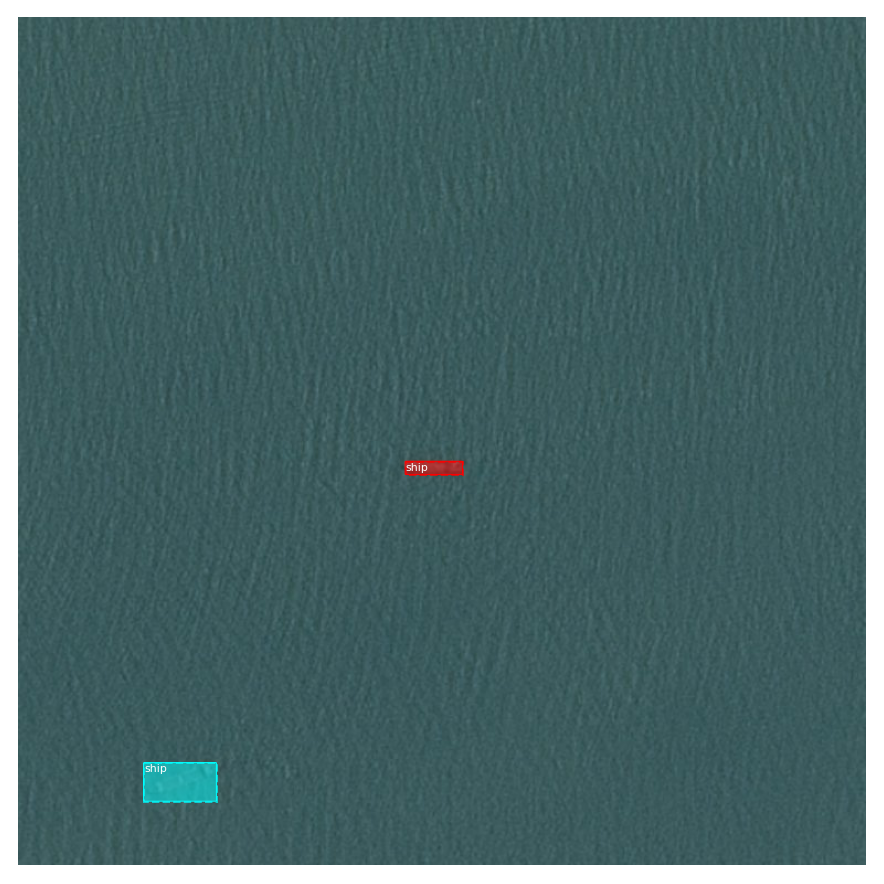

In [ ]:
# define image id
image_id = 0
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [ ]:
from matplotlib import pyplot

(768, 768, 3)
(768, 768, 2)


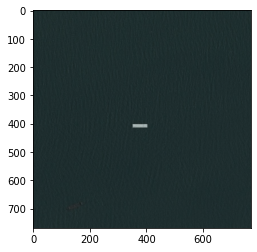

In [ ]:
# train set
train_set = AirBusDataset()
train_set.load_dataset('/content/drive/MyDrive/Colab Notebooks/AirBus', is_train=True)
train_set.prepare()
image_id = 0
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
# plot image
pyplot.imshow(image)
# plot mask for one ship
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
pyplot.show()

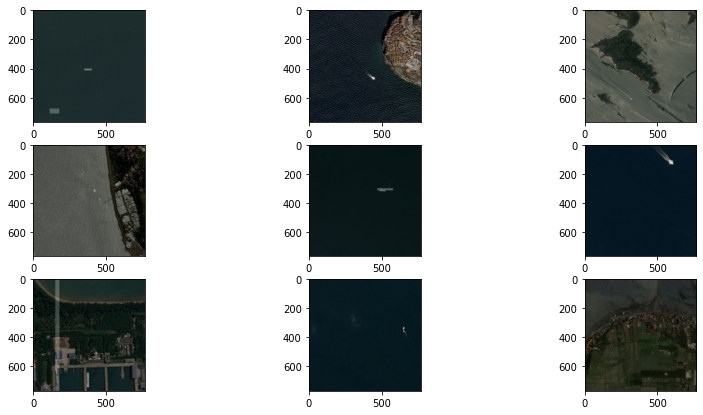

In [ ]:
# plot first few images
pyplot.rcParams["figure.figsize"] = (14,7)
for i in range():
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	image = train_set.load_image(i)
	pyplot.imshow(image)
	# plot all masks
	mask, _ = train_set.load_mask(i)
	for j in range(mask.shape[2]):
		pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
# show the figure
pyplot.show()

In [ ]:
# enumerate 10 images in the dataset
for image_id in train_set.image_ids[:10]:
	# load image info
	info = train_set.image_info[image_id]
	# display on the console
	print(info)

{'id': 0, 'source': 'dataset', 'path': '/content/drive/MyDrive/Colab Notebooks/AirBus/Data/31afc6724.jpg', 'annotation': '/content/drive/MyDrive/Colab Notebooks/AirBus/train_ship_segmentations_v2.csv'}
{'id': 1, 'source': 'dataset', 'path': '/content/drive/MyDrive/Colab Notebooks/AirBus/Data/31a290a86.jpg', 'annotation': '/content/drive/MyDrive/Colab Notebooks/AirBus/train_ship_segmentations_v2.csv'}
{'id': 2, 'source': 'dataset', 'path': '/content/drive/MyDrive/Colab Notebooks/AirBus/Data/31a01ac53.jpg', 'annotation': '/content/drive/MyDrive/Colab Notebooks/AirBus/train_ship_segmentations_v2.csv'}
{'id': 3, 'source': 'dataset', 'path': '/content/drive/MyDrive/Colab Notebooks/AirBus/Data/31ab675db.jpg', 'annotation': '/content/drive/MyDrive/Colab Notebooks/AirBus/train_ship_segmentations_v2.csv'}
{'id': 4, 'source': 'dataset', 'path': '/content/drive/MyDrive/Colab Notebooks/AirBus/Data/31aa7693b.jpg', 'annotation': '/content/drive/MyDrive/Colab Notebooks/AirBus/train_ship_segmentations